loss is defined as the follows: loss= sum(pairwise_distance) / sum(distance_of_medoids)

In [1]:
from medoid_lib import api
import matplotlib.pyplot as plt
import importlib
# importlib.reload(api)

In [2]:
from medoid_lib.dtw_lib._dtw_lib import fastdtw
f = lambda x, y: fastdtw(x, y, 1)[0]

In [48]:
# def calculate_loss(medoids, matrix):
def get_pairwise(cluster, matrix):
    length = len(cluster)
    sum = 0
    count = 0
    for i in range(length):
        for j in range(i, length):
            sum += matrix[i][j]
            count += 1
    return sum / length

def get_pairwise_medoids(medoids, f):
    length = len(medoids)
    sum = 0
    count = 0
    for i in range(0, length):
        for j in range(i, length):
            sum += f(medoids[i], medoids[j])
            count += 1
    return sum

def get_loss_for_num(segs, matrix, k, f, mode='complete'):
    represents = api.get_medoids(matrix, segs, k, 0)
    medoids = list(map(lambda r: r[0], represents))
    clusters = api.convert_label_to_clusters(api.get_hieratical_cluster(matrix, k, mode))
    numerator= 0
    for c in clusters:
        numerator += get_pairwise(c, matrix)
    denominator = get_pairwise_medoids(medoids, f)
    return numerator / k

In [5]:
num = 3
label_matrix = api.get_hieratical_cluster(matrix, num)
clusters = api.convert_label_to_clusters(label_matrix)

In [4]:
segs, matrix = api.load(['medoid/data/user2_Standing_segments_5', 'medoid/data/user2_Standing_matrix_5'])

In [9]:
get_loss_for_num(segs, matrix, 6, f, 'average')

25906.09090542077

In [11]:
represents = api.get_medoids(matrix, segs, num, 0)

In [55]:
medoids = map(lambda r: r[0], represents)
get_pairwise_medoids(list(medoids), f)

9.70430504233333

In [27]:
get_pairwise(clusters[0], matrix)
medoid_index = map(lambda m: m[])
get_pairwise()

3939.780675783424

In [40]:
medoids = list(map(lambda r: r[0], api.get_medoids(matrix, segs, 2, 0)))

0.0

In [18]:
def plot_num(user, label, f, mode='complete'):
    name = 'medoid/data/user' + str(user) + '_' + label;
    segs, matrix = api.load([name + '_segments_5', name + '_matrix_5'])
    x = list(range(1, 10))
    y = []
    for i in x:
        y.append(get_loss_for_num(segs, matrix, i, f, mode))
    plt.title(str(user) + "_" + label)
    plt.plot(x, y)

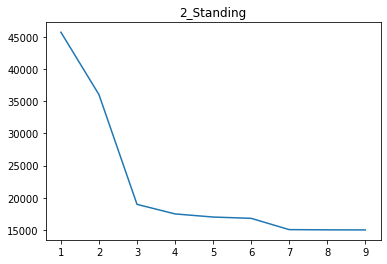

In [15]:
plot_num(2, 'Standing', f)

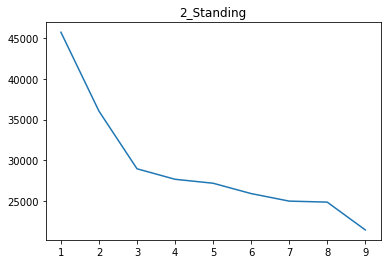

In [14]:
plot_num(2, 'Standing', f, 'average')

In [22]:
def point_to_line_dist(start, end, point):
    import math
    a = 1.0 * (start[1] - end[1]) / (start[0] - end[0])
    c = end[1] - a * end[0]
    return abs(a * point[0] - point[1] + c) / math.sqrt(a **2 + 1)
import numpy as np

In [20]:
def get_elbow(points):
    start = points[0]
    end = points[-1]
    dist = list(map(lambda p: point_to_line_dist(start, end, p), points))
    return np.argmax(dist) + 1

In [16]:
def get_cluster_num(user, label, f, mode='complete'):
    name = 'medoid/data/user' + str(user) + '_' + label;
    segs, matrix = api.load([name + '_segments_5', name + '_matrix_5'])
    x = list(range(1, 10))
    y = []
    for i in x:
        y.append(get_loss_for_num(segs, matrix, i, f, mode))
    points = list(map(lambda i: (i, y[i - 1]), x))
    return get_elbow(points)

In [17]:
def get_points(user, label, f, mode='complete'):
    name = 'medoid/data/user' + str(user) + '_' + label;
    segs, matrix = api.load([name + '_segments_5', name + '_matrix_5'])
    x = list(range(1, 10))
    y = []
    for i in x:
        y.append(get_loss_for_num(segs, matrix, i, f, mode))
    points = list(map(lambda i: (i, y[i - 1]), x))
    return points

In [51]:
get_points(1, 'Standing', f)

[(1, 8616.748449472385),
 (2, 5542.6415436448515),
 (3, 1638.8231134319094),
 (4, 1434.9069656653166),
 (5, 1336.3801138823403),
 (6, 1252.1769152810023),
 (7, 1157.3708958432655),
 (8, 1149.2719060566596),
 (9, 908.8494223612953)]

In [58]:
get_elbow([(1, 8616.748449472385), (2, 5542.6415436448515), (9, 908.8494223612953)])

[0.0, 2.190603050928231, 0.0]

(3, None)

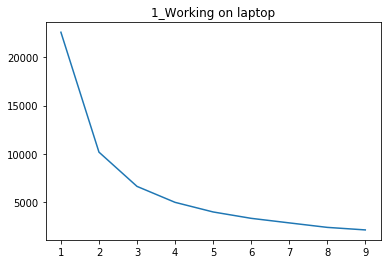

In [50]:
user, label, mode = 1, 'Working on laptop', 'average'
get_cluster_num(user, label, f, mode), plot_num(user, label, f, mode)

(2, None)

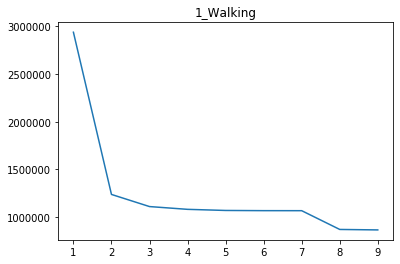

In [26]:
user, label, mode = 1, 'Walking', 'complete'
get_cluster_num(user, label, f, mode), plot_num(user, label, f, mode)